In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np
import os
import itertools

# Read Confusion

In [2]:
test_epoch = 10
dataname = "DBLP2_10000"

In [3]:
def read_confusion_matrices(dirpath, fname="log_test_confusion.txt", ep=100):
    if os.path.isfile(dirpath + fname) is False:
        return -1
    num_epoch = test_epoch
    with open(dirpath + fname, "r") as f:
        three_line = []
        for line in f.readlines():
            if len(three_line) == 3:
                num_epoch += test_epoch
                if num_epoch >= ep:
                    break
                three_line = []
            three_line.append(line)
    if num_epoch < ep:
        return -1
    confusion_matrix = np.zeros((3,3))
    for i in range(3):
        line = three_line[i].rstrip()
        c1, c2, c3 = line.split("\t")
        c1, c2, c3 = int(c1), int(c2), int(c3)
        confusion_matrix[i,0] = c1
        confusion_matrix[i,1] = c2
        confusion_matrix[i,2] = c3
    
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1] + confusion_matrix[2,2]) / (np.sum(confusion_matrix))
    
    rec_bar = []
    label_num = []
    recall_micro_denom = 0
    recall_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        row_sum = np.sum(confusion_matrix[i])
        label_num.append(row_sum)
        ans = confusion_matrix[i,i]
        if row_sum == 0:
            rec_bar.append(0)
        else:
            rec_bar.append(ans / row_sum)
        recall_micro_denom += row_sum
        recall_micro_numer += ans
    
    recall_macro = sum(rec_bar) / 3
    recall_micro = recall_micro_numer / recall_micro_denom
    
    prec_bar = []
    pred_label_num = []
    precision_micro_denom = 0
    precision_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        col_sum = np.sum(confusion_matrix[:,i])
        pred_label_num.append(col_sum)
        ans = confusion_matrix[i,i]
        if col_sum == 0:
            prec_bar.append(0)
        else:
            prec_bar.append(ans / col_sum)
        precision_micro_denom += col_sum
        precision_micro_numer += ans
    precision_macro = sum(prec_bar) / 3
    precision_micro = precision_micro_numer / precision_micro_denom
    
    f1_bar = []
    for i in range(len(rec_bar)):
        if (prec_bar[i] + rec_bar[i]) == 0:
            f1_bar.append(0)
        else:
            f1_bar.append(2 * ( (prec_bar[i] * rec_bar[i]) / (prec_bar[i] + rec_bar[i]) ))
    f1score_macro = sum(f1_bar) / 3
    f1score_micro = 2 * ( (precision_micro * recall_micro) / (precision_micro + recall_micro))
    
    numlabelrate = []
    for i in range(3):
        numlabelrate.append(pred_label_num[i] / label_num[i])
    
    result = {
        "accuracy" : accuracy,
        "f1_micro": f1score_micro,
        "f1_macro": f1score_macro,
        "num_epoch" : num_epoch
    }
    for i in range(3):
        result["recall_" + str(i)] = rec_bar[i]
        result["precision_" + str(i)] = prec_bar[i]
        result["f1_" + str(i)] = f1_bar[i]
        result["labelratio_" + str(i)] = numlabelrate[i]
    return result

# Make Dict

In [4]:
resultdict = defaultdict(dict)
ep=30

baselinename_list = ["baseline1", "baseline0"]
nongraph_list = ["RandomForest", "MLP", "LogisticRegressor"]

In [5]:
for baselinename in baselinename_list:
    res = read_confusion_matrices("../nongraph_results/" + dataname + "/", fname= baselinename + "_confusion.txt", ep=10)
    assert res != -1, baselinename
    res["searchspace"] = 1
    resultdict[baselinename] = res

In [6]:
for nongraphmodel in nongraph_list:
    res = read_confusion_matrices("../nongraph_results/" + dataname + "/" + nongraphmodel + "/", fname= "All_confusion.txt", ep=10)
    assert res != -1, nongraphmodel
    res["searchspace"] = 1
    resultdict[nongraphmodel] = res

In [7]:
# Add F1 macro
for initvec in ["onehot", "adj", "rw"]:
    orgdir = "../results/" + dataname + "/" + initvec + "/"
    for modelname in os.listdir(orgdir):
        modelnamedir = orgdir + modelname + "/"
        if os.path.isdir(modelnamedir) is False:
            continue
        param2f1macro = {}
        for paramname in os.listdir(modelnamedir):
            paramnamedir = modelnamedir + paramname + "/"
            if os.path.isfile(paramnamedir + "log_test_confusion.txt"):
                res = read_confusion_matrices(paramnamedir, ep=30)
                if res != -1:
                    param2f1macro[paramname] = res["f1_macro"]
                
        if os.path.isfile(modelnamedir + "param_result2.txt"):
            d = pd.read_csv(modelnamedir + "param_result2.txt")
        elif os.path.isfile(modelnamedir + "param_result.txt"):
            d = pd.read_csv(modelnamedir + "param_result.txt")
            d = d.drop_duplicates(['parameter'], keep='last')
            paramlist = list(d['parameter'])
            f1macrolist = [param2f1macro[p] for p in paramlist]
            d["F1macro"] = f1macrolist
            d.to_csv(modelnamedir + "param_result2.txt", index=False)
            #d = d.sort_values(by=["ValidAcc"], ascending=False)
        else:
            continue
        
        d = d.sort_values(by=["F1macro"], ascending=False)
        for i, row in d.iterrows():
            paramdir = row["parameter"]
            break
        res = read_confusion_matrices(modelnamedir + paramdir + "/", ep=30)
        if res == -1:
            print(modelname)
        else:
            res["searchspace"] = len(param2f1macro)
            resultdict[modelname + "/" + initvec] = res

transformer-pure-Att_nl2_sm_snl1
transformer-RankQ-pure_nl2_partial_sm_snl1
transformer-pure-HNHN_nl2_sm_snl1
transformer-sum-AvgAggRes_nl2_sm_snl1
transformer-RankQ-pure_nl2_partial_sm_snl1
gat-sum_nl2_sm_snl1
transformer-RankQ-PrevQ_nl2_partial_sm_snl1
transformer-RankQ-pure_nl2_partial_sm_snl1


In [8]:
evallist = ["f1_micro", "f1_macro"] + list(itertools.chain.from_iterable([["recall_" + str(i),  "precision_" + str(i), "f1_" + str(i), 'labelratio_' + str(i)] for i in range(3)]))
print(evallist)
print(len(evallist))

['f1_micro', 'f1_macro', 'recall_0', 'precision_0', 'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1', 'labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2']
14


In [9]:
outputname = "search0314_{}.txt".format(dataname)
with open(outputname, "w") as f:
    line = "Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer," + ",".join(evallist) + ",searchspace"
    f.write(line + "\n")

In [10]:
for k in resultdict:
    if k in baselinename_list:
        model = k
        initvec, encode, decode, partialflag, scorer = "-", "-", "-", "-", "-"
        nl, snl = 0, 0        
    elif k in nongraph_list:
        model = k
        initvec, encode, decode, partialflag, scorer = "-", "-", "-", "-", "-"
        nl, snl = 0, 0
    else:
        tmp = k.split("/")
        assert len(tmp) == 2
        initvec = tmp[-1]
        _k = tmp[0]
        if "partial" in _k:
            partialflag = "partial"
            modelname, nl, _, scorer, snl = _k.split("_")
        else:
            partialflag = "-"
            modelname, nl, scorer, snl = _k.split("_")
        if "transformer" in modelname:
            model,encode, decode = modelname.split("-")
        else:
            tmp = modelname.split("-")
            if len(tmp) == 1:
                model = tmp[0]
                encode = "-"
            elif len(tmp) == 2:
                model = tmp[0]
                encode = tmp[1]
            decode = "-"

        nl = int(nl[2:])
        snl = int(snl[3:])
        
    line = [model, initvec, encode, decode, partialflag, str(nl), scorer, str(snl)] + [str(resultdict[k][e]) for e in evallist] + [str(resultdict[k]["searchspace"])]
    line = ",".join(line)
    with open(outputname, "a") as f:
        f.write(line + "\n")

In [11]:
d = pd.read_csv(outputname)
d = d[d["Decode"] != "AvgAggRes"]
d = d[d["Decode"] != "PureRes"]
d = d[d["Scorer"] == "sm"]
d = d.sort_values(by=["f1_macro"], ascending=False)
d

,Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer,f1_micro,f1_macro,...,labelratio_0,recall_1,precision_1,f1_1,labelratio_1,recall_2,precision_2,f1_2,labelratio_2,searchspace
47,transformer,rw,RankQ,AvgAgg,-,2,sm,1,0.768116,0.751285,...,0.9755,0.873816,0.738813,0.800664,1.182730,0.5405,0.776023,0.637194,0.6965,16
50,transformer,rw,sum,AvgAgg,-,2,sm,1,0.756917,0.742838,...,1.0675,0.826462,0.748675,0.785648,1.103900,0.5570,0.746649,0.638030,0.7460,2
49,transformer,rw,pure,AvgAgg,-,2,sm,1,0.730303,0.719498,...,1.0760,0.771588,0.742826,0.756934,1.038719,0.5720,0.669397,0.616878,0.8545,16
60,transformer,rw,RankQ,pure,-,2,sm,1,0.728327,0.718826,...,0.9315,0.788022,0.731953,0.758954,1.076602,0.6190,0.664876,0.641119,0.9310,5
46,transformer,rw,sum,pure,-,2,sm,1,0.735705,0.715701,...,0.9935,0.845404,0.721931,0.778804,1.171031,0.5165,0.738385,0.607826,0.6995,5
33,transformer,adj,RankQ,AvgAgg,-,2,sm,1,0.590119,0.570119,...,0.8775,0.672423,0.638455,0.654999,1.053203,0.5665,0.551607,0.558954,1.0270,2
35,transformer,adj,sum,AvgAgg,-,2,sm,1,0.604216,0.567655,...,0.6835,0.767131,0.625909,0.689362,1.225627,0.5265,0.577619,0.550876,0.9115,3
45,transformer,adj,RankQ,pure,-,2,sm,1,0.607905,0.559649,...,0.6375,0.824791,0.613806,0.703827,1.343733,0.4545,0.609658,0.520768,0.7455,5
32,transformer,adj,sum,pure,-,2,sm,1,0.598946,0.551497,...,0.6230,0.806407,0.610888,0.695161,1.320056,0.4720,0.588162,0.523717,0.8025,5
34,transformer,adj,pure,AvgAgg,-,2,sm,1,0.582872,0.542937,...,0.7620,0.755710,0.619548,0.680888,1.219777,0.4610,0.546532,0.500136,0.8435,6


In [12]:
# a = d[d["Encode"] == "sum"]
a = d.groupby(by=['Encode']).mean()
a

,NumLayer,ScorerNumLayer,f1_micro,f1_macro,recall_0,precision_0,f1_0,labelratio_0,recall_1,precision_1,f1_1,labelratio_1,recall_2,precision_2,f1_2,labelratio_2,searchspace
Encode,,,,,,,,,,,,,,,,,
-,2.0,1.0,0.499846,0.413661,0.271917,0.440277,0.314907,0.611833,0.769545,0.534644,0.625431,1.448097,0.243667,0.435454,0.300645,0.583833,5.833333
PosEnc,2.0,1.0,0.576548,0.508261,0.323167,0.516142,0.397243,0.626500,0.842618,0.602624,0.702664,1.398329,0.352333,0.535040,0.424875,0.658500,12.000000
RankQ,2.0,1.0,0.627527,0.583186,0.483167,0.600897,0.530802,0.790278,0.810970,0.644485,0.716124,1.265756,0.440833,0.606399,0.502633,0.729500,9.555556
pure,2.0,1.0,0.518696,0.404214,0.343400,0.388562,0.323955,0.793050,0.777827,0.562225,0.624483,1.435627,0.228850,0.355983,0.264204,0.425000,7.500000
sum,2.0,1.0,0.588549,0.512435,0.387917,0.523442,0.423126,0.709083,0.833635,0.615064,0.703243,1.377739,0.349250,0.575206,0.410935,0.612875,5.166667


## Initial Vec

* initial vector 방법마다 6가지를 bar로 표현
* table을 initial vector로 groupby
* transformer-RankQ-AvgAgg/* 만 바꾸면서 여러 evaluation

## Encode

* initial vector 방법마다 6가지를 bar로 표현
* table을 initial vector로 groupby
* transformer-RankQ-AvgAgg/* 만 바꾸면서 여러 evaluation
* ranking을 쓰는 것이 좋은가라는 질문 답하기: transformer, gat, hnhn 각각 대표 하나로...!

## Partial

* 가장 좋은 성능 보이는 모델과 partial을 비교

## Total Comparison

* HNHN / GAT / Transformer - X / Rank + baseline 살펴보기

In [109]:
encodercolor = {
    "PosEnc" : "#e41a1c",
    "RankQ" : "#377eb8",
    "adj" : "#4daf4a",
    "pure" : "#984ea3", #"orange", #"#984ea3",
    "sum" : "#ff7f00",
    "rw" : "#ffff33",
    "partial": "green",
    "RandomForest": "gray"
}
decodercolor = {
    "AvgAgg" : "#e41a1c",
    "AvgAggRes" : "#377eb8",
    "pure" : "#4daf4a",
    "PrevQ" : "#984ea3",
    "pureRes" : "#ff7f00",
    "RandomForest": "gray"
}
initialveccolor = {
    "rw": 'red',
    "adj":  "green",
    "onehot":  "skyblue"
}

In [57]:
# grouplist = defaultdict(dict)
# for iv in ["rw", "adj", "onehot"]:
#     for encode in ["RankQ", "sum", "pure"]:
#         for decode in ["AvgAgg", "pure"]:
#             grouplist[iv][encode + "-" + decode] = "transformer-" + encode + "-" + decode + "_nl2_sm_snl1"+ "/" + iv

# grouplist = defaultdict(dict)
# for encode in ["RankQ", "sum", "pure"]:
#     for iv in ["rw", "adj", "onehot"]:
#         for decode in ["AvgAgg", "pure"]:
#             grouplist[encode][iv + "/" + decode] = "transformer-" + encode + "-" + decode + "_nl2_sm_snl1"+ "/" + iv

grouplist = defaultdict(dict)
for encode in ["RankQ", "pure"]:
    for iv in ["rw"]: #["rw", "adj", "onehot"]:
        if iv not in grouplist:
            grouplist[encode][iv] = []
        for decode in ["AvgAgg", "PrevQ"]:
            grouplist[encode][iv].append("transformer-" + encode + "-" + decode + "_nl2_sm_snl1"+ "/" + iv)

In [58]:
def plot_total_eval(dictlist, colordict, result, w = 1 / 4):
    fig, axes = plt.subplots(dpi=100, figsize=(12,4), nrows=1, ncols=2)
    
    keylist = list(dictlist.keys())
    xs = list(dictlist[keylist[0]].keys())
    
    for eidx, evalname in enumerate(["f1_micro", "f1_macro"]):
        for kidx, key in enumerate(keylist):
            ys = []
            for x in xs:
                y = []
                for modelname in dictlist[key][x]:
                    if modelname not in result:
                        continue
                    y.append(result[modelname][evalname])
                if len(y) == 0 :
                    ys.append(0)
                else:
                    ys.append(np.mean(y))
            axes[eidx].bar(np.arange(len(xs)) + (w*(kidx-1)), ys, width=w, align='center', label=key, color=colordict[key])
            
        axes[eidx].set_xticks(np.arange(len(xs)))
        axes[eidx].set_xticklabels(xs, fontsize=13, rotation=90)
        axes[eidx].set_title(evalname, fontsize=20)
        axes[eidx].autoscale(tight=True)
        axes[eidx].hlines(result["RandomForest"][evalname], -0.5, len(xs) - 0.5, linestyle="dashed", color="black", label="RandomForest")
        if eidx == 1:
            axes[eidx].legend(bbox_to_anchor=(1,1))

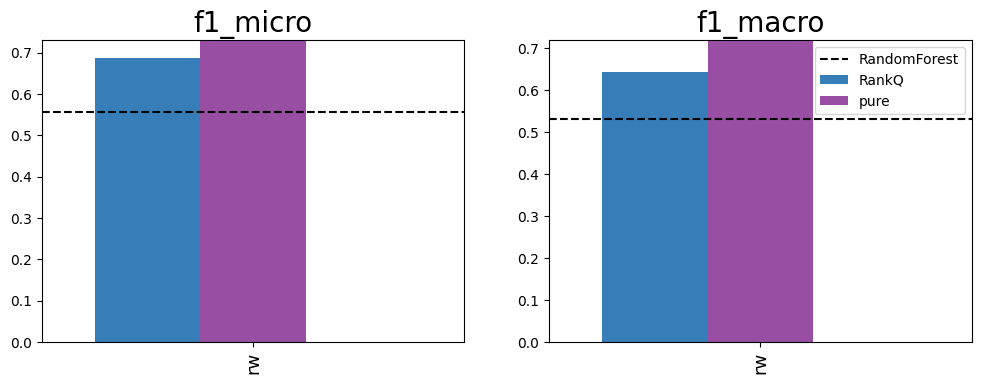

In [59]:
# plot_total_eval(grouplist, initialveccolor, resultdict)
plot_total_eval(grouplist, encodercolor, resultdict)

In [122]:
# label2name = {
#     "rw" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/rw",
#     "adj": "transformer-RankQ-AvgAgg_nl2_sm_snl1/adj",
#     "onehot": "transformer-RankQ-AvgAgg_nl2_sm_snl1/onehot",
# }

# label2name = {
#     "RankQ" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/rw",
# #     "sum": "transformer-sum-AvgAgg_nl2_sm_snl1/rw",
#     "pure": "transformer-pure-AvgAgg_nl2_sm_snl1/rw",
# }
# label2legend = {
#     "RankQ" : "OurModel(Ranking)",
#     "pure": "OurModel(w/oRanking)",
# }

# label2name = {
#     "RankQ" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/rw",
#     "partial" : "transformer-RankQ-AvgAgg_nl2_partial_sm_snl1/rw",
#     "pure": "transformer-pure-pure_nl2_sm_snl1/rw",
# }
# label2legend = {
#     "RankQ" : "OurModel(Ranking)",
#     "partial" : "OurModel(Partial)",
#     "pure": "SetTransformer",
# }

label2name = {
    "OurModel" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/onehot",
    "HNHN": "hnhn_nl2_sm_snl1/onehot",
    "HAT": "gat_nl2_sm_snl1/onehot",
    "RandomForest": "RandomForest"
}
# label2legend = {
#     "RankQ" : "OurModel(Ranking)",
#     "pure": "OurModel(w/oRanking)",
# }

In [123]:
def plot_label_detail(label2name,colordict, result, w=1/5):
    plt.figure(dpi=100, figsize=(6,4))
    
    evallist = ['f1_micro', 'f1_macro', 'f1_0', 'f1_1', 'f1_2'] #, 'labelratio_' + str(l)] # ['labelratio_' + str(l) for l in range(3)] # 
    for lidx, label in enumerate(label2name.keys()):
        ys = [result[label2name[label]][e] for e in evallist]
        if label not in colordict:
            plt.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label)
        else:
            plt.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label, color=colordict[label])

    # ys = [result["RandomForest"][e] for e in evallist]
    # minx, maxx = plt.xlim()
    # plt.hlines(1, minx, maxx, linestyle="dashed", color="black", linewidth=4)

    ax = plt.gca()
    ax.set_xticks(np.arange(len(evallist)))
    ax.set_xticklabels(evallist, fontsize=13)

    plt.legend(bbox_to_anchor=(1,1), fontsize=15)
    # ax.xaxis_date()

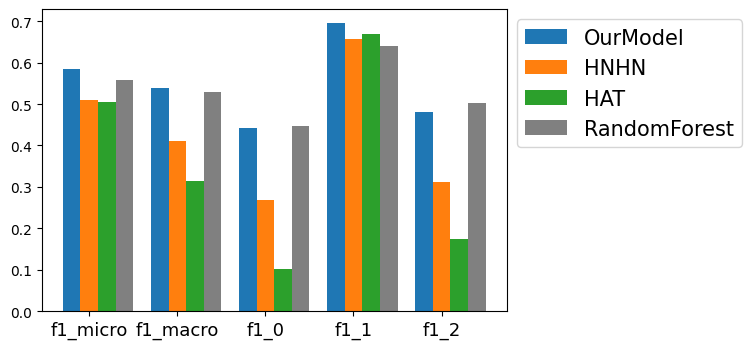

In [124]:
plot_label_detail(label2name, encodercolor, resultdict)

In [125]:
def plot_label_detail(label2name,colordict, result, w=1/5):
    fig, axes = plt.subplots(dpi=100, figsize=(20,4), nrows=1, ncols=3)

    for l in range(3):
        ax = axes[l]
        evallist = ['recall_' + str(l), 'precision_' + str(l), 'f1_' + str(l), 'labelratio_' + str(l)]
        for lidx, label in enumerate(label2name.keys()):
            ys = [result[label2name[label]][e] for e in evallist]
            if label not in colordict:
                ax.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label)
            else:
                ax.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label, color=colordict[label])
        
        # ys = [result["RandomForest"][e] for e in evallist]
        # ax.plot(evallist, ys, linestyle="dashed", color="black", label="RandomForest", linewidth=7)
        minx, maxx, _, _ = ax.axis()
        ax.hlines(1, minx, maxx, linestyle="dashed", color="black", linewidth=4)
    
        ax.set_xticks(np.arange(len(evallist)))
        ax.set_xticklabels(evallist, fontsize=13)

        if l == 2:
            ax.legend(bbox_to_anchor=(1,1), fontsize=15)
        # ax.xaxis_date()
        ax.set_title("Label : " + str(l), fontsize=15)
        ax.autoscale(tight=True)

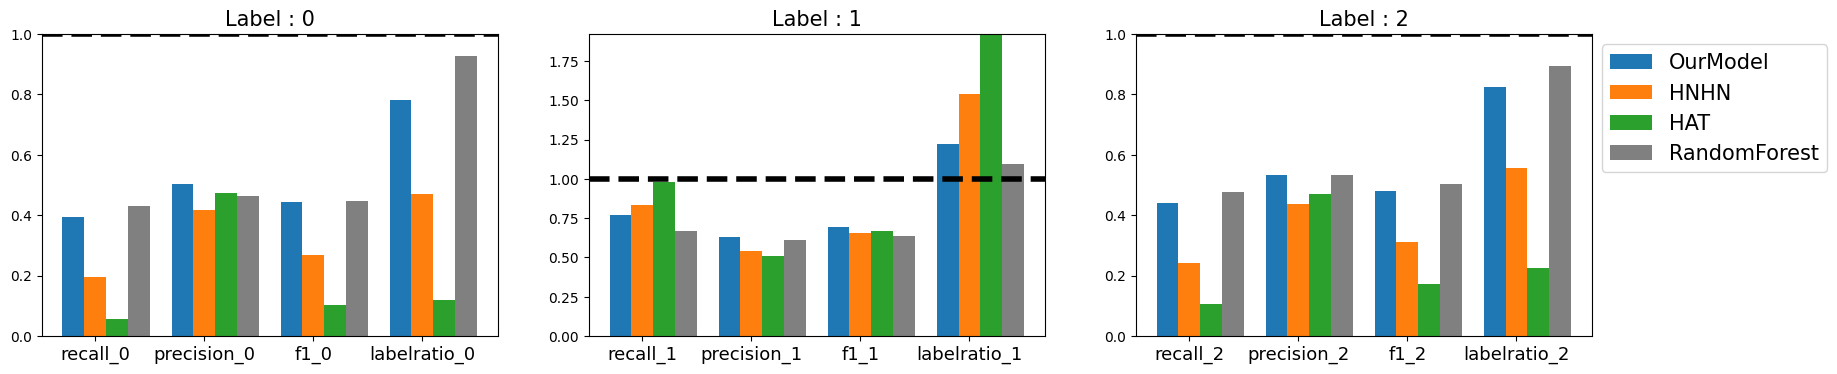

In [126]:
plot_label_detail(label2name, encodercolor, resultdict)

In [70]:
showcolumn = ['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'NumLayer', 'Scorer',
       'ScorerNumLayer', 'f1_micro', 'f1_macro','f1_0', 'labelratio_0','f1_1', 'labelratio_1', 'f1_2', 'labelratio_2']

In [71]:
d[showcolumn].head(20)

,Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer,f1_micro,f1_macro,f1_0,labelratio_0,f1_1,labelratio_1,f1_2,labelratio_2
47,transformer,rw,RankQ,AvgAgg,-,2,sm,1,0.768116,0.751285,0.815996,0.9755,0.800664,1.182730,0.637194,0.6965
49,transformer,rw,sum,AvgAgg,-,2,sm,1,0.756917,0.742838,0.804837,1.0675,0.785648,1.103900,0.638030,0.7460
48,transformer,rw,pure,AvgAgg,-,2,sm,1,0.730303,0.719498,0.784682,1.0760,0.756934,1.038719,0.616878,0.8545
59,transformer,rw,RankQ,pure,-,2,sm,1,0.728327,0.718826,0.756407,0.9315,0.758954,1.076602,0.641119,0.9310
46,transformer,rw,sum,pure,-,2,sm,1,0.735705,0.715701,0.760472,0.9935,0.778804,1.171031,0.607826,0.6995
33,transformer,adj,RankQ,AvgAgg,-,2,sm,1,0.590119,0.570119,0.496405,0.8775,0.654999,1.053203,0.558954,1.0270
35,transformer,adj,sum,AvgAgg,-,2,sm,1,0.604216,0.567655,0.462726,0.6835,0.689362,1.225627,0.550876,0.9115
45,transformer,adj,RankQ,pure,-,2,sm,1,0.607905,0.559649,0.454351,0.6375,0.703827,1.343733,0.520768,0.7455
56,transformer,rw,RankQ,AvgAgg,partial,2,sm,1,0.615415,0.556690,0.590172,1.0045,0.724549,1.268245,0.355350,0.5140
32,transformer,adj,sum,pure,-,2,sm,1,0.598946,0.551497,0.435613,0.6230,0.695161,1.320056,0.523717,0.8025


## Groupby

In [72]:
a = d[d["Encode"] != "PosEnc"]
a['name'] = a['Model'] + "-" + a["Encode"] + "-" + a["Partial"]

for exceptname in ["transformer-sum-", "transformer-sum-partial", 'transformer-pure-partial']:
    a = a[a["name"] != exceptname]
a = a.loc[a.groupby(['name'])['f1_macro'].idxmax()]
a

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer,f1_micro,f1_macro,...,recall_1,precision_1,f1_1,labelratio_1,recall_2,precision_2,f1_2,labelratio_2,searchspace,name
4,LogisticRegressor,-,-,-,-,0,-,0,0.534680,0.443809,...,0.825134,0.557500,0.665414,1.480060,0.37475,0.478455,0.420300,0.78325,1,LogisticRegressor----
3,MLP,-,-,-,-,0,-,0,0.552919,0.479868,...,0.813348,0.576998,0.675084,1.409620,0.39375,0.510039,0.444413,0.77200,1,MLP----
2,RandomForest,-,-,-,-,0,-,0,0.557430,0.530253,...,0.670412,0.610965,0.639310,1.097300,0.47675,0.533277,0.503432,0.89400,1,RandomForest----
1,baseline0,-,-,-,-,0,-,0,0.335948,0.329427,...,0.330958,0.478123,0.391156,0.692202,0.33450,0.265108,0.295789,1.26175,1,baseline0----
0,baseline1,-,-,-,-,0,-,0,0.477022,0.215308,...,1.000000,0.477022,0.645924,2.096341,0.00000,0.000000,0.000000,0.00000,1,baseline1----
52,gat,rw,-,-,-,2,sm,1,0.498287,0.438797,...,0.719499,0.549224,0.622935,1.310028,0.25350,0.383510,0.305238,0.66100,3,gat----
37,gat,adj,sum,-,-,2,sm,1,0.500000,0.381979,...,0.863510,0.507033,0.638912,1.703064,0.15500,0.647182,0.250101,0.23950,5,gat-sum--
54,hnhn,rw,-,-,-,2,sm,1,0.521212,0.493391,...,0.630084,0.569343,0.598175,1.106685,0.30500,0.363962,0.331882,0.83800,6,hnhn----
47,transformer,rw,RankQ,AvgAgg,-,2,sm,1,0.768116,0.751285,...,0.873816,0.738813,0.800664,1.182730,0.54050,0.776023,0.637194,0.69650,4,transformer-RankQ--
56,transformer,rw,RankQ,AvgAgg,partial,2,sm,1,0.615415,0.556690,...,0.821727,0.647924,0.724549,1.268245,0.26900,0.523346,0.355350,0.51400,2,transformer-RankQ-partial


In [73]:
a.columns

Index(['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'NumLayer', 'Scorer',
       'ScorerNumLayer', 'f1_micro', 'f1_macro', 'recall_0', 'precision_0',
       'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1',
       'labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2',
       'searchspace', 'name'],
      dtype='object')

In [74]:
postprocessed_result = {}
for i, row in a.iterrows():
    res = {}
    for colname in ['f1_micro', 'f1_macro', 'recall_0', 'precision_0', 'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1','labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2']:
        res[colname] = row[colname]
    postprocessed_result[row["name"]] = res

In [75]:
modelcolor = {
    "baseline0----" : "#000000",
    "baseline1----": "#000000",
    
    # brown
    "RandomForest----": "#9A7745", 
    "MLP----": "#D27328",
    "LogisticRegressor----": "#8B4513",
    
    # dark
    "hnhn----": "#440075",
    "transformer-pure--": "#0000FF",
    "gat----": "#CD1039",
    
    # mid
    #       red
    "gat-sum--": "#FF7A85",
    #       blue
    "transformer-RankQ--": "#0078FF",
    "transformer-RankQ-partial": "#64CD3C", 
    
    # light
#     "limit/gat_concat": "#FFCD28", 
#     "limit/gat_sum": "#FFCD28",
#     #       green -> yellow green
#     "limit/transformer_concat": "#64CD3C", 
#     "limit/transformer_sum": "#64CD3C", 
#     "limit/transformer2": "#64CD3C"
}

In [76]:
modellist = ['transformer-RankQ--', 'transformer-RankQ-partial', 'transformer-pure--', 'gat-sum--', 'gat----', 'hnhn----']
# modellist = ['transformer-RankQ--', 'transformer-pure--', 'gat-sum--', 'gat----', 'hnhn----']
baseline = ['RandomForest----']

In [77]:
def plot_total_eval2(modellist, baseline, colordict, result):
    fig, axes = plt.subplots(dpi=100, figsize=(12,4), nrows=1, ncols=2)
    
    xs = modellist
    
    for eidx, evalname in enumerate(["f1_micro", "f1_macro"]):
        for modelname in modellist + baseline:
            if modelname not in result:
                continue
            axes[eidx].bar(modelname, result[modelname][evalname], align='center', label=modelname, color=colordict[modelname])
            
        axes[eidx].set_xticks([])
#         axes[eidx].set_xticklabels(xs, fontsize=13, rotation=90)
        axes[eidx].set_title(evalname)
        axes[eidx].autoscale(tight=True)
        if eidx == 1:
            axes[eidx].legend(bbox_to_anchor=(1,1))

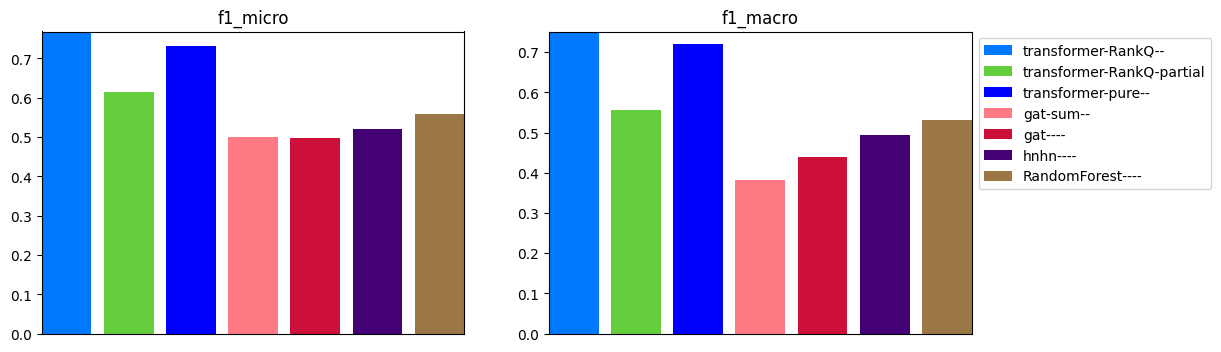

In [78]:
plot_total_eval2(modellist, baseline, modelcolor, postprocessed_result)

In [79]:
def plot_label_detail2(modellist, baseline, colordict, result, w=1/7):
    fig, axes = plt.subplots(dpi=100, figsize=(20,4), nrows=1, ncols=3)

    for l in range(3):
        ax = axes[l]
        evallist = ['recall_' + str(l), 'precision_' + str(l), 'f1_' + str(l), 'labelratio_' + str(l)]
        for midx, modelname in enumerate(modellist):
            if modelname not in result:
                continue
            ys = [result[modelname][e] for e in evallist]
            ax.bar(np.arange(len(evallist)) + (w * (midx-2)), ys, width=w, align='center', label=modelname, color=colordict[modelname])
        for midx, modelname in enumerate(baseline):
            xs = []
            ys = []
            for eidx, e in enumerate(evallist):
                for i in range(len(modellist)):
                    ys.append(result[modelname][e])
                    xs.append(eidx + w * (i - 2))
            ax.plot(xs, ys, label=modelname, color=colordict[modelname], linewidth=4, linestyle="dashed")
        
        ax.set_xticks(np.arange(len(evallist)))
        ax.set_xticklabels(evallist, fontsize=13)

        if l == 2:
            ax.legend(bbox_to_anchor=(1,1))
        # ax.xaxis_date()
        ax.set_title("Label : " + str(l))
        ax.autoscale(tight=True)

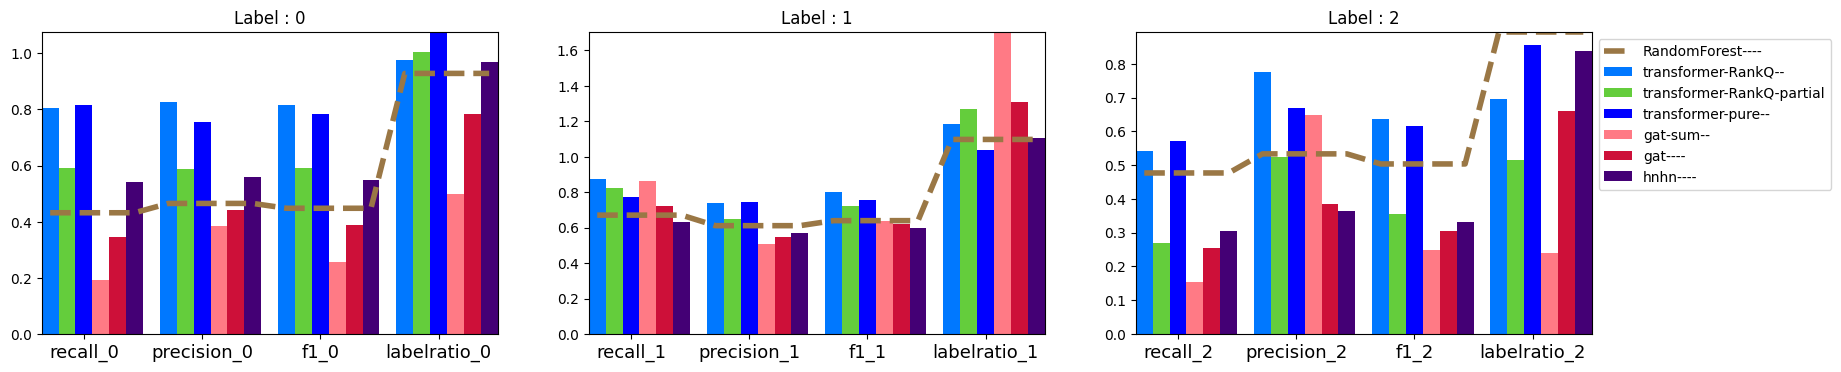

In [80]:
plot_label_detail2(modellist, baseline, modelcolor, postprocessed_result)